In [1]:
import pandas as pd
import numpy as np
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print(pg.__version__)

0.5.1


Benchmarking results and best fully trained hyperparametres are read in from the output CSV files of each benchmarking script.

In [3]:
# read in benchmark results
benchmark_CDE = pd.read_csv('../data/processed/cde_f1.csv')
benchmark_CDE['name'] = 'CDE'
benchmark_CDE['n_cols'] = 1
benchmark_chemonly = pd.read_csv('../data/processed/chemonly_f1.csv')
benchmark_chemonly['name'] = 'chem_only'
benchmark_chemonly['n_cols'] = 0
benchmark_max_slope_steady = pd.read_csv('../data/processed/max_slope_steady_f1.csv')
benchmark_max_slope_steady['name'] = 'max_slope_steady'
benchmark_max_slope_steady['n_cols'] = 3
benchmark_mean_disco_effect = pd.read_csv('../data/processed/mean_disco_effect_raw_f1.csv')
benchmark_mean_disco_effect['name'] = 'full_disco_effect'
benchmark_mean_disco_effect['n_cols'] = 7


In [4]:
# read in fully trained model hyperparameters
hyp_CDE = pd.read_csv('../data/processed/cde_bestparams.csv')
hyp_CDE['name'] = 'CDE'
hyp_CDE['random_seed'] = benchmark_CDE.random_seed
hyp_chemonly = pd.read_csv('../data/processed/chem_bestparams.csv')
hyp_chemonly['name'] = 'chem_only'
hyp_chemonly['random_seed'] = benchmark_CDE.random_seed
hyp_max_slope_steady = pd.read_csv('../data/processed/maxsteadyslope_bestparams.csv')
hyp_max_slope_steady['name'] = 'max_slope_steady'
hyp_max_slope_steady['random_seed'] = benchmark_CDE.random_seed
hyp_mean_disco_effect = pd.read_csv('../data/processed/meandiscoeffect_bestparams.csv')
hyp_mean_disco_effect['name'] = 'full_disco_effect'
hyp_mean_disco_effect['random_seed'] = benchmark_CDE.random_seed


In [5]:
benchmarking_results = pd.concat([benchmark_mean_disco_effect, benchmark_max_slope_steady, benchmark_CDE, benchmark_chemonly]).drop(columns = "Unnamed: 0").reset_index(drop=True)
fully_trained_hyperparameters = pd.concat([hyp_CDE, hyp_chemonly, hyp_max_slope_steady, hyp_mean_disco_effect]).drop(columns = 'Unnamed: 0').reset_index(drop=True)

# merge tables and display benchmarking results
results_summary = benchmarking_results.merge(right=fully_trained_hyperparameters, how='left', on = ['name', 'random_seed'])

print("Benchmarking Results:")
display(results_summary)

Benchmarking Results:


,random_seed,fully_trained_f1,holdout_f1,name,n_cols,dt__max_depth,dt__min_samples_leaf,dt__min_samples_split
0,148,0.818681,0.571892,full_disco_effect,7,4,5,2
1,0,0.817190,0.582719,full_disco_effect,7,4,7,2
2,601,0.728592,0.571892,full_disco_effect,7,4,20,2
3,148,0.857963,0.546703,max_slope_steady,3,4,3,7
4,0,0.857963,0.523225,max_slope_steady,3,4,3,7
5,601,0.898148,0.498734,max_slope_steady,3,5,3,7
6,148,0.869737,0.551284,CDE,1,5,3,2
7,0,0.818681,0.530063,CDE,1,5,3,15
8,601,0.812025,0.558642,CDE,1,4,5,40
9,148,0.660140,0.446064,chem_only,0,4,10,30


In [6]:
# see final_model_paper notebook for baseline F1 computation
majority_clf_baseline_f1 = 0.46

Examine average pipeline results:

In [7]:
average_benchmarking = benchmarking_results.groupby(["name"]).mean().drop(columns = ['random_seed'])

display(average_benchmarking)

,fully_trained_f1,holdout_f1,n_cols
name,,,
CDE,0.833481,0.546663,1.0
chem_only,0.660140,0.439689,0.0
full_disco_effect,0.788154,0.575501,7.0
max_slope_steady,0.871358,0.522888,3.0


Next, statistically compare holdout performance using ANOVA. Null hypothesis, all pipelines have equal holdout performance from nested cross validation.

In [8]:
anova_data = benchmarking_results.copy().drop(columns=['n_cols', 'fully_trained_f1'])

In [9]:
display(anova_data)

,random_seed,holdout_f1,name
0,148,0.571892,full_disco_effect
1,0,0.582719,full_disco_effect
2,601,0.571892,full_disco_effect
3,148,0.546703,max_slope_steady
4,0,0.523225,max_slope_steady
5,601,0.498734,max_slope_steady
6,148,0.551284,CDE
7,0,0.530063,CDE
8,601,0.558642,CDE
9,148,0.446064,chem_only


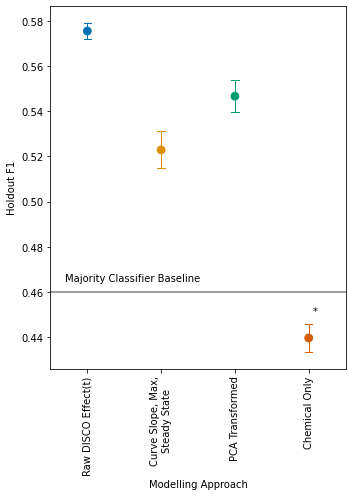

In [12]:
fig, ax = plt.subplots(figsize = (5,7))
sns.pointplot(data=anova_data, x='name', y='holdout_f1', dodge=True, markers=['o', 's'],
              capsize=.1, errwidth=1, palette='colorblind', ax=ax, ci=68) # shows SEM for error bars at 68
plt.xticks(rotation=90)
plt.axhline(y=majority_clf_baseline_f1, color='gray', linestyle='-')
plt.ylabel("Holdout F1")
plt.xlabel("Modelling Approach")
plt.xticks(ticks=(range(0,4)), labels=["Raw DISCO Effect(t)", "Curve Slope, Max,\nSteady State", "PCA Transformed", "Chemical Only"])
ax.text(s='*', x=3.05, y=0.45)
ax.text(s='Majority Classifier Baseline', x=-0.3, y=0.465)

plt.tight_layout()
plt.savefig("../figures/supplementary/benchmarking_results.png", dpi=1200)
plt.savefig("../figures/supplementary/benchmarking_results.svg", dpi=1200)
plt.show()


<b> Test each variable for normality and equality of variance:

In [13]:
from scipy import stats

x1 = anova_data.loc[anova_data['name'] == "full_disco_effect"]['holdout_f1']
x2 = anova_data.loc[anova_data['name'] == "max_slope_steady"]['holdout_f1']
x3 = anova_data.loc[anova_data['name'] == "CDE"]['holdout_f1']
x4 = anova_data.loc[anova_data['name'] == "chem_only"]['holdout_f1']


View the quantile plots to assess normality:

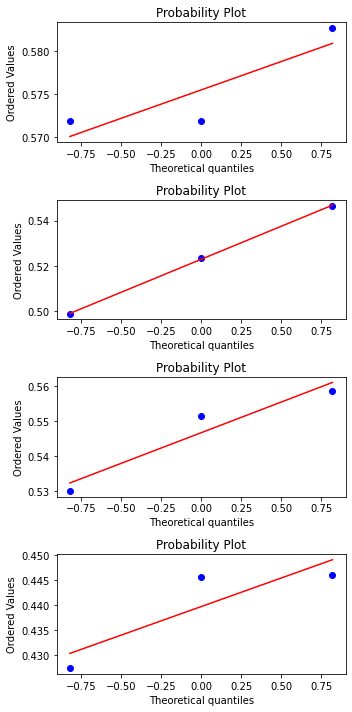

In [14]:
fig, ax = plt.subplots((4), figsize = (5,10))
xs = [x1,x2,x3,x4]
for i in range(0,4):
    stats.probplot(xs[i], dist="norm", plot=ax[i])
    
plt.tight_layout()
plt.show()


Test for equal variance. Null hypothesis, all groups have equal variances. If unequal variance, p value will be < 0.05. 

In [15]:
print(stats.bartlett(x1,x2,x3,x4))

BartlettResult(statistic=2.846386854274407, pvalue=0.4159206316998384)


p > 0.05, therefore we fail to reject the null hypothesis of equal variance.

In [16]:
pg.anova(data=anova_data, dv='holdout_f1', between='name')

,Source,ddof1,ddof2,F,p-unc,np2
0,name,3,8,43.154507,0.000028,0.941803


The ANOVA showed all mean holdout scores are not equal (p<0.05, n=3). 

Use post hoc t-test for pairwise multiple comparisons with Bonferroni correction to identify any significant comparisons between approaches.

In [17]:
import scikit_posthocs as sp

print("The p values for comparisons across modelling approach are:")
sp.posthoc_ttest(anova_data, val_col='holdout_f1', group_col='name', sort=True, p_adjust='bonferroni')

The p values for comparisons across modelling approach are:


,CDE,chem_only,full_disco_effect,max_slope_steady
CDE,1.000000,0.003217,0.216906,1.000000
chem_only,0.003217,1.000000,0.000274,0.032285
full_disco_effect,0.216906,0.000274,1.000000,0.127625
max_slope_steady,1.000000,0.032285,0.127625,1.000000


In [18]:
print(sp.__version__)


0.7.0


<b>From this, we learn (n=3, p<0.05):</b>
* Chemical descriptors pipeline did not beat the majority classifier baseline, and performed statistically worse than pipelines incorporating DISCO Effect.
* No statistically significant differences between different DISCO Effect feature implementations in terms of holdout F1.


### Feature Selection Benchmarking Takeaways

* Chemical only descriptors are insufficient, need to include DISCO Effect(t) derived feature(s) to model structure-interaction.

* The object of this work is primarily exploratory, hence selecting the CDE pipeline simplifies trend interpretation. 

* In downstream predictive works, out of sample predictive power may be improved by using all DISCO Effect(t) saturation times as independent variables in modelling.
